***

# __Utilizing Machine Learning for High Frequency Algorithmic Trading__


##### __Name:__ Masixole Boya<br>__Student number:__ 1869204

***

# __Imports__

In [1]:
from datetime import datetime
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import dask.dataframe as dd
import numpy as np
import pandas as pd
from scipy.stats import linregress
import json
from scipy.stats import linregress
# import MetaTrader5 as mt5
import mplfinance as mpf
import warnings
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import tensorflow 
from tensorflow import keras
from keras.models import Sequential
from keras.metrics import RootMeanSquaredError
from tensorflow.keras import layers
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import pytz
import wandb
# from wandb.keras import WandbCallback, WandbMetricsLogger
from wandb.integration.keras import WandbCallback,WandbMetricsLogger

# from secret_login import Secret_Login, IC_Markets_Login, Wandb_Login
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.models import load_model
import sys

# sys.path.append('../../login_info')
sys.path.append('../../modules')


# Load the credentials from the JSON file
# with open('../../login_info/login_info.json', 'r') as f:
#     credentials = json.load(f)

# import MT5_IC_secret_login
# from MT5_IC_secret_login import Secret_Login, IC_Markets_Login, Wandb_Login, OctaFx_Login



# from MT5_IC_login_function import login_to_mt5
# from mt5_ic_login_function import login_to_mt5



c:\Users\tshol\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### __Imports to be disregarded on remote__

In [2]:
import MetaTrader5 as mt5
from mt5_ic_login_function import login_to_mt5

# __1. MetaTrader 5 API__ : Setup

### __1.1 Initialize Application__

In [3]:
mt5.initialize()

True

### __1.2 Login__


In [4]:
login_success = login_to_mt5()

51944578
ICMarketsSC-Demo
Account : 51944578
Password : @0p63lC@FWABrr
Server : ICMarketsSC-Demo
Connected to account #51944578


# __2. MetaTrader 5 API__ : Retrieving Data

In [5]:
ticker = 'EURUSD'
frequency = mt5.TIMEFRAME_M1

# Define the date range correctly
to_date = datetime.now()
from_date = datetime(2024, 5, 5)

In [6]:
range_rates = mt5.copy_rates_range(ticker, frequency, from_date, to_date)

range_rates

array([(1714953600, 1.07661, 1.07693, 1.07589, 1.0759 ,   6,  0, 0),
       (1714953660, 1.07609, 1.07615, 1.07594, 1.07611,   9, 42, 0),
       (1714953720, 1.07616, 1.07616, 1.07616, 1.07616,   1, 40, 0), ...,
       (1727481240, 1.11594, 1.116  , 1.11593, 1.11594,  88,  0, 0),
       (1727481300, 1.11594, 1.11629, 1.1159 , 1.11628, 113,  0, 0),
       (1727481360, 1.11628, 1.11663, 1.11628, 1.11632,  81,  0, 0)],
      dtype=[('time', '<i8'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('tick_volume', '<u8'), ('spread', '<i4'), ('real_volume', '<u8')])

In [7]:
data = pd.DataFrame(range_rates)
data

time     open     high      low    close  tick_volume  spread  \
0       1714953600  1.07661  1.07693  1.07589  1.07590            6       0   
1       1714953660  1.07609  1.07615  1.07594  1.07611            9      42   
2       1714953720  1.07616  1.07616  1.07616  1.07616            1      40   
3       1714953780  1.07604  1.07631  1.07604  1.07631            6      30   
4       1714953840  1.07631  1.07631  1.07631  1.07631            1      22   
...            ...      ...      ...      ...      ...          ...     ...   
150760  1727481120  1.11597  1.11602  1.11591  1.11591           12       0   
150761  1727481180  1.11591  1.11597  1.11591  1.11594           56       0   
150762  1727481240  1.11594  1.11600  1.11593  1.11594           88       0   
150763  1727481300  1.11594  1.11629  1.11590  1.11628          113       0   
150764  1727481360  1.11628  1.11663  1.11628  1.11632           81       0   

        real_volume  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
150760            0  
150761            0  
150762            0  
150763            0  
150764            0  

[150765 rows x 8 columns]

### ------------------ save data file, delete if exists ---------------------------------

In [8]:
# data.to_csv('range_rates.csv', index=False)

### ------------------- move data file to remote ---------------------------------

scp range_rates.csv mboya@146.141.21.100:/home-mscluster/mboya/capstone_project_remote/Capstone_Project/trainedModel_historical/MetaTrader5

# --------------- __START RUNNING ON REMOTE__ --------------

In [9]:
# data = pd.read_csv("range_rates.csv")
# data.sample(3)

In [10]:
# data['time'] = pd.to_datetime(data['time'],unit = 's')

In [11]:
# print(f'first time : \n{data.head(1)['time']}')
# print(f"\nLast time : \n{data.tail(1)['time'] }")

# __3. Preprocessing Data__

### __3.1 Data Cleaning__ 

In [12]:
def clean_data(data):
    
    # 1. Remove duplicate rows
    print("------- Removing Duplicate Rows -------")
    duplicates = data[data.duplicated()]
    if not duplicates.empty:
        print("Duplicate rows found and removed:\n", duplicates)
    else:
        print("No duplicate rows found.")
    data = data.drop_duplicates()
    
    # 2. Handle missing values
    print("\n------- Handling Missing Values -------")
    missing_values = data[data.isnull().any(axis=1)]
    if not missing_values.empty:
        print("Rows with missing values found and handled:\n", missing_values)
    else:
        print("No missing values found.")
    data = data.dropna()

    # 3. Convert data types if necessary
    print("\n------- Converting Data Types -------")
    if 'time' in data.columns:
        # data['time'] = pd.to_datetime(data['time'], unit='s')
        data['time'] = pd.to_datetime(data['time'],unit = 's')
        print("'time' column converted to datetime.")

     # 4. Remove specific columns: tick_volume, spread, real_volume
    print("\n------- Removing non-OHLC Columns -------")
    columns_to_remove = ['tick_volume', 'spread', 'real_volume']
    existing_columns = [col for col in columns_to_remove if col in data.columns]
    if existing_columns:
        print(f"Removing columns: {existing_columns}")
        data = data.drop(columns=existing_columns)
    else:
        print("No columns to remove.")

    # 4. Remove any rows where OHLC values are 0
    print("\n------- Removing Rows with Zero OHLC Values -------")
    ohlc_columns = ['open', 'high', 'low', 'close']
    zero_ohlc = data[(data[ohlc_columns] == 0).any(axis=1)]
    if not zero_ohlc.empty:
        print("Rows with zero OHLC values found and removed:\n", zero_ohlc)
    else:
        print("No rows with zero OHLC values found.")
    data = data[(data[ohlc_columns] != 0).all(axis=1)]
    
    # 5. (Optional) Handle outliers
    # print("\n------- Handling Outliers (if any) -------")
    # This is where you could implement outlier handling and print details.
    # Example: using Z-score method, etc.
    
    print("\nData cleaning complete.")
    return data


In [13]:

data = clean_data(data)
data

------- Removing Duplicate Rows -------
No duplicate rows found.

------- Handling Missing Values -------
No missing values found.

------- Converting Data Types -------
'time' column converted to datetime.

------- Removing non-OHLC Columns -------
Removing columns: ['tick_volume', 'spread', 'real_volume']

------- Removing Rows with Zero OHLC Values -------
No rows with zero OHLC values found.

Data cleaning complete.


time     open     high      low    close
0      2024-05-06 00:00:00  1.07661  1.07693  1.07589  1.07590
1      2024-05-06 00:01:00  1.07609  1.07615  1.07594  1.07611
2      2024-05-06 00:02:00  1.07616  1.07616  1.07616  1.07616
3      2024-05-06 00:03:00  1.07604  1.07631  1.07604  1.07631
4      2024-05-06 00:04:00  1.07631  1.07631  1.07631  1.07631
...                    ...      ...      ...      ...      ...
150760 2024-09-27 23:52:00  1.11597  1.11602  1.11591  1.11591
150761 2024-09-27 23:53:00  1.11591  1.11597  1.11591  1.11594
150762 2024-09-27 23:54:00  1.11594  1.11600  1.11593  1.11594
150763 2024-09-27 23:55:00  1.11594  1.11629  1.11590  1.11628
150764 2024-09-27 23:56:00  1.11628  1.11663  1.11628  1.11632

[150765 rows x 5 columns]

### __3.2 Exploratory Data Analysis__

In [14]:
def full_eda(data):
    
    warnings.filterwarnings('ignore')
    # 1. Data Information
    print("------- Data Information --------\n")
    print(data.info())
    
    # 2. Data Description
    print("\n---------- Data Description ----------\n")
    print(pd.DataFrame(data.describe()))
    
    # 3. Pairplot for All Columns
    print("\n---------- Pairplot ----------")
    sns.pairplot(data[['open', 'high', 'low', 'close']], diag_kind='kde', plot_kws={'alpha': 0.5})
    plt.figure(figsize=(5, 5))
    plt.show()
    
    # # 6. Line Plot for Close Price
    # print("\n---------- Line Plot for Close Price ----------")
    # plt.figure(figsize=(10, 5))
    # plt.plot(data['close'], label='Close Price')
    # plt.title('Close Price Over Time')
    # plt.xlabel('Date')
    # plt.ylabel('Close Price')
    # plt.legend()
    # plt.show()
    
    # 4. Convert 'time' to datetime and Set Index
    data['time'] = pd.to_datetime(data['time'], unit='s')  # Convert Unix timestamp to datetime
    data.set_index('time', inplace=True)
    
    # 5. Candlestick Chart
    print("\n---------- Candlestick Chart ----------")
    last_hour_data = data.last('1H')
    if not last_hour_data.empty:
        mpf.plot(last_hour_data, type='candle', style='charles', title='Candlestick Chart for the Last Hour', ylabel='Price')
    else:
        print("No data available for the last hour.")
    
    # mpf.plot(data, type='candle', style='charles', title='Candlestick Chart', ylabel='Price')
    
    

    # 7. Histograms and KDEs for OHLC Data
    print("\n---------- Distribution of OHLC ----------")
    plt.figure(figsize=(10, 5))
    columns = ['open', 'high', 'low', 'close']
    for i, col in enumerate(columns):
        plt.subplot(2, 2, i + 1)  # 2x2 grid for 4 plots
        sns.histplot(data[col], kde=True, bins=30, color=sns.color_palette("tab10")[i])
        plt.title(f'{col.capitalize()} Distribution')
    plt.tight_layout()
    plt.show()

    # 8. Box Plots for OHLC Data
    print("\n---------- Box Plot ----------")
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=data[columns])
    plt.title('Box Plots for OHLC Data')
    plt.xlabel('OHLC')
    plt.ylabel('Value')
    plt.show()

    # # # 9. Multiply Values by 100,000 and Plot Again
    # # print("\n---------- Multiplying OHLC values by 100,000 and Plotting Again ----------")
    # # data_scaled = data[columns] * 100000
    # # plt.figure(figsize=(14, 10))
    # # for i, col in enumerate(columns):
    # #     plt.subplot(2, 2, i + 1)  # 2x2 grid for 4 plots
    # #     sns.histplot(data_scaled[col], kde=True, bins=30, color=sns.color_palette("tab10")[i])
    # #     plt.title(f'{col.capitalize()} Distribution (Scaled)')
    # # plt.tight_layout()
    # # plt.show()

    
    # New Section: Plot Prices for Each Minute by Day of the Week for the First Week
    
    print("\n---------- Daily Variations by minute  ----------")
    # Filter data for August 2024 based on the time column
    august_data = data[(data.index.month == 8) & (data.index.year == 2024)].copy()  # Make a copy for August 2024 data

    # Create a column for 'minute_of_day' (time in minutes from 00:00)
    august_data['minute_of_day'] = august_data.index.hour * 60 + august_data.index.minute

    # Get unique days in August from the time column
    unique_days_in_august = august_data.index.normalize().unique()

    # Plot each day's closing prices
    plt.figure(figsize=(8, 4))

    for day in unique_days_in_august:
        day_data = august_data[august_data.index.normalize() == day]
        
        # Only plot if the day has data
        if not day_data.empty:
            plt.plot(day_data['minute_of_day'], day_data['close'], label=day.strftime('%Y-%m-%d'), alpha=0.7)

    # Set plot titles and labels
    plt.title('Closing Prices for Each Day of August 2024 by Minute of the Day')
    plt.xlabel('Minute of the Day')
    plt.ylabel('Close Price')

    # Set x-ticks to represent each hour (0 to 1440 minutes for 24 hours)
    plt.xticks(ticks=range(0, 1441, 60), labels=[f"{i // 60:02d}:{i % 60:02d}" for i in range(0, 1441, 60)], rotation=45)
    plt.xlim(0, 1440)  # 0 to 1440 minutes (24 hours)

    # Add grid, legend, and adjust layout
    plt.grid()
    plt.legend(title='Day of August', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
        


 # --- August 2024 Dates Based on the Calendar ---
    august_dates = {
        'Monday': ['2024-08-05', '2024-08-12', '2024-08-19', '2024-08-26'],
        'Tuesday': ['2024-08-06', '2024-08-13', '2024-08-20', '2024-08-27'],
        'Wednesday': ['2024-08-07', '2024-08-14', '2024-08-21', '2024-08-28'],
        'Thursday': ['2024-08-01', '2024-08-08', '2024-08-15', '2024-08-22', '2024-08-29'],
        'Friday': ['2024-08-02', '2024-08-09', '2024-08-16', '2024-08-23', '2024-08-30'],
        'Saturday': ['2024-08-03', '2024-08-10', '2024-08-17', '2024-08-24', '2024-08-31'],
        'Sunday': ['2024-08-04', '2024-08-11', '2024-08-18', '2024-08-25']
    }

    # Create a column for 'minute_of_day' (time in minutes from 00:00) in a temporary dataframe
    temp_data = data.copy()  # Use a copy of the original dataframe
    temp_data['minute_of_day'] = temp_data.index.hour * 60 + temp_data.index.minute

    # --- Section 1: Plot Combined Days of Week (All Mondays, All Tuesdays, etc.) ---
    print("\n---------- Section 1: Combined Weekdays ----------")

    plt.figure(figsize=(8, 4))
    for day, dates in august_dates.items():
        day_data = temp_data[temp_data.index.normalize().isin(pd.to_datetime(dates))]  # Use the temporary dataframe
        avg_day_data = day_data.groupby('minute_of_day')['close'].mean()
        plt.plot(avg_day_data.index, avg_day_data.values, label=day, alpha=0.7)

    plt.title('Combined Days: Average Close Price for Each Day of Week (August 2024)')
    plt.xlabel('Minute of the Day')
    plt.ylabel('Average Close Price')
    plt.xticks(ticks=range(0, 1441, 60), labels=[f"{i // 60:02d}:{i % 60:02d}" for i in range(0, 1441, 60)], rotation=45)  # Set x-ticks for each hour
    plt.xlim(0, 1440)  # 0 to 1440 minutes (24 hours)
    plt.grid()
    plt.legend(title='Day of the Week')
    plt.tight_layout()
    plt.show()

    # --- Section 2: Individual Weekdays with Lines for Each Weekday ---
    print("\n---------- Section 2: Individual Weekdays ----------")

    for day, dates in august_dates.items():
        plt.figure(figsize=(8, 4))
        for date in dates:
            specific_day_data = temp_data[temp_data.index.normalize() == pd.to_datetime(date)]  # Use the temporary dataframe
            if not specific_day_data.empty:
                plt.plot(specific_day_data['minute_of_day'], specific_day_data['close'], label=date, alpha=0.7)
        
    plt.title(f'Close Prices for Each Minute of the Day - {day}s (August 2024)')
    plt.xlabel('Minute of the Day')
    plt.ylabel('Close Price')
    plt.xticks(ticks=range(0, 1441, 60), labels=[f"{i // 60:02d}:{i % 60:02d}" for i in range(0, 1441, 60)], rotation=45)
    plt.xlim(0, 1440)
    plt.grid()
    plt.legend(title=f'Each {day}', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()




------- Data Information --------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150765 entries, 0 to 150764
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   time    150765 non-null  datetime64[ns]
 1   open    150765 non-null  float64       
 2   high    150765 non-null  float64       
 3   low     150765 non-null  float64       
 4   close   150765 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 5.8 MB
None

---------- Data Description ----------

                                time           open           high  \
count                         150765  150765.000000  150765.000000   
mean   2024-07-17 11:36:00.485523456       1.090926       1.090979   
min              2024-05-06 00:00:00       1.066720       1.066810   
25%              2024-06-11 05:35:00       1.080470       1.080530   
50%              2024-07-17 11:32:00       1.087300       1.087340   
75%            

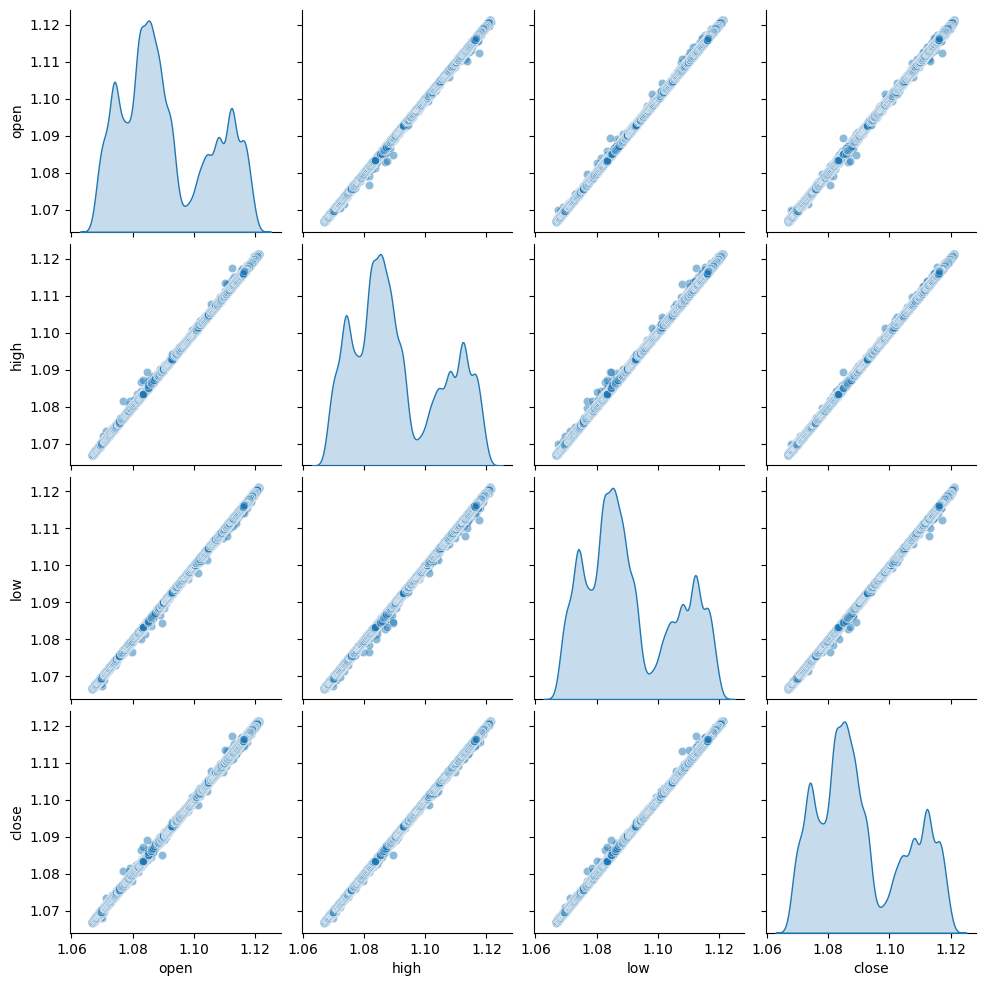

<Figure size 500x500 with 0 Axes>


---------- Candlestick Chart ----------


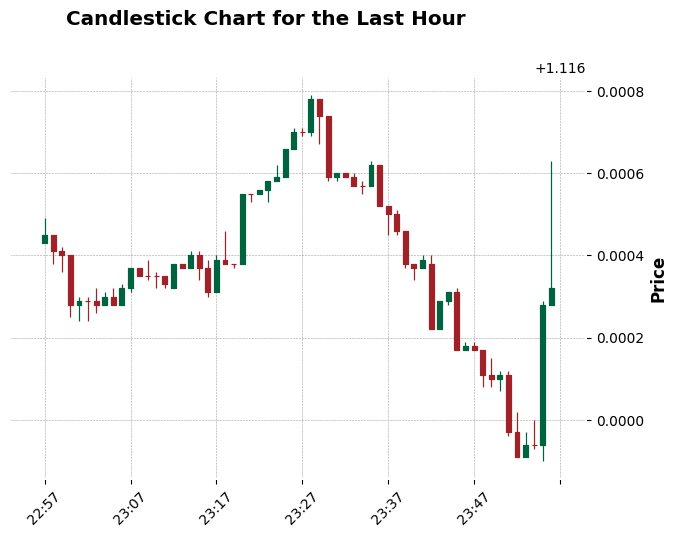


---------- Distribution of OHLC ----------


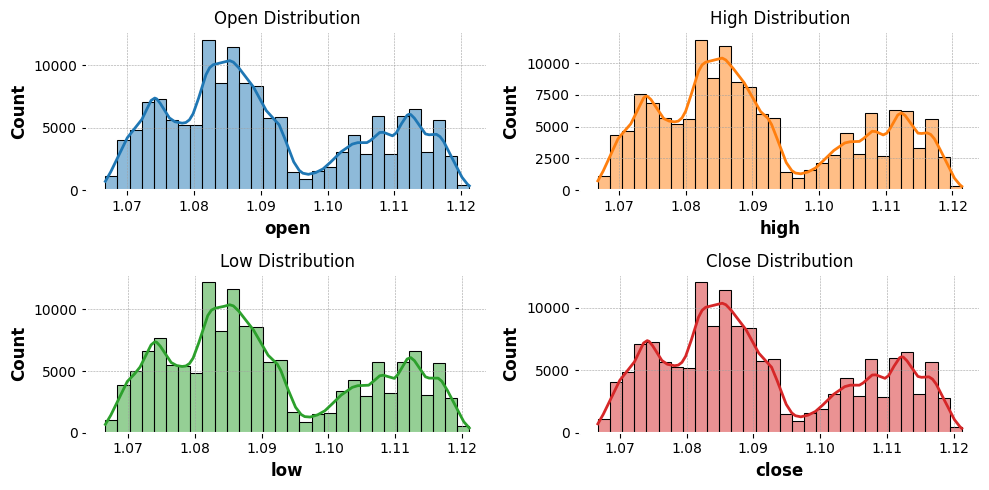


---------- Box Plot ----------


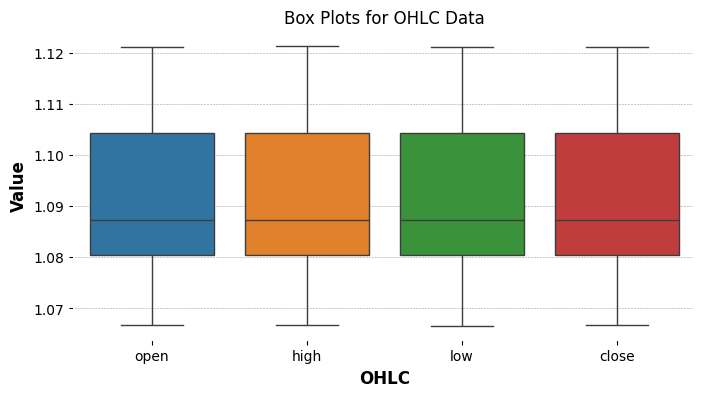


---------- Daily Variations by minute  ----------


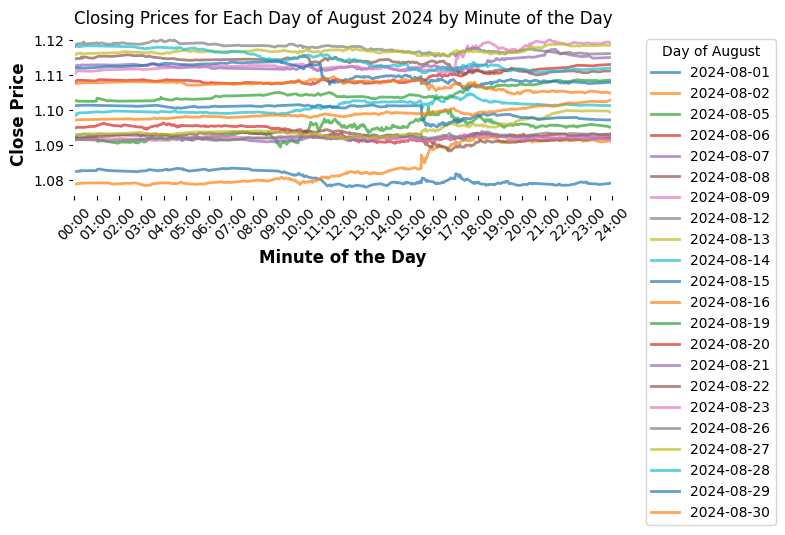


---------- Section 1: Combined Weekdays ----------


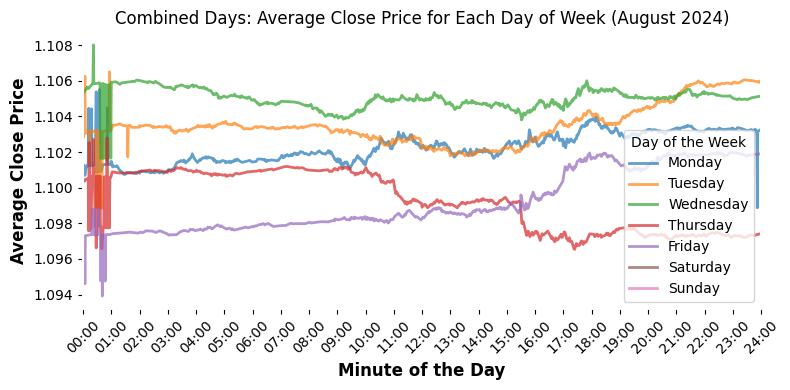


---------- Section 2: Individual Weekdays ----------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


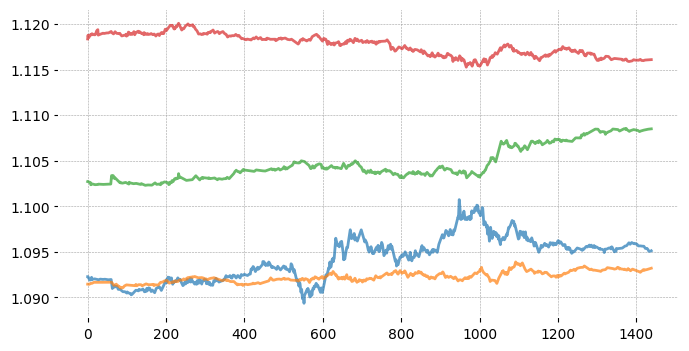

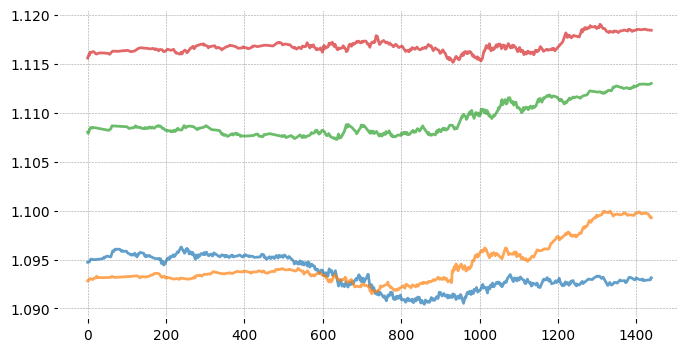

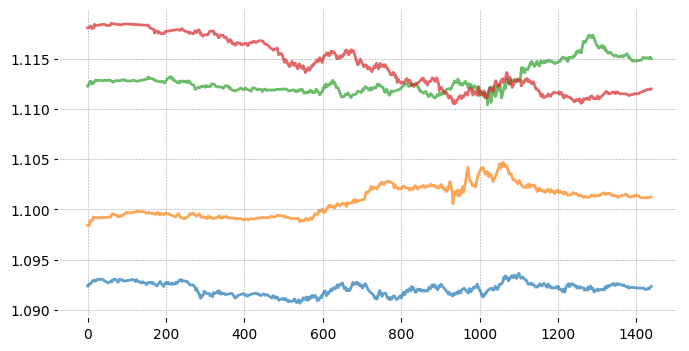

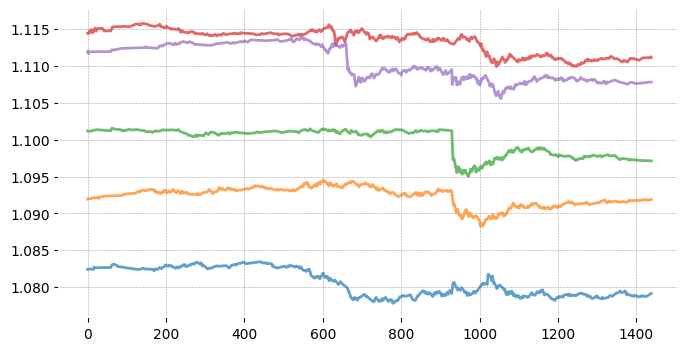

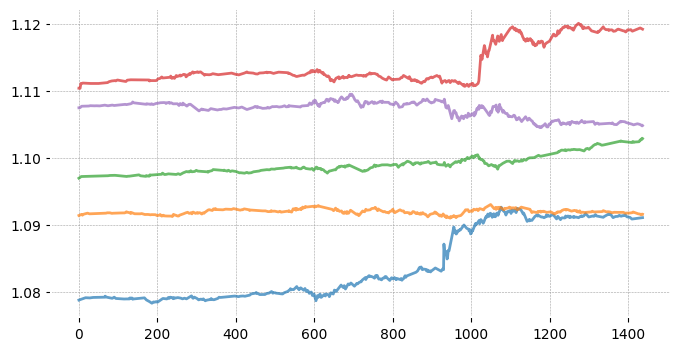

<Figure size 800x400 with 0 Axes>

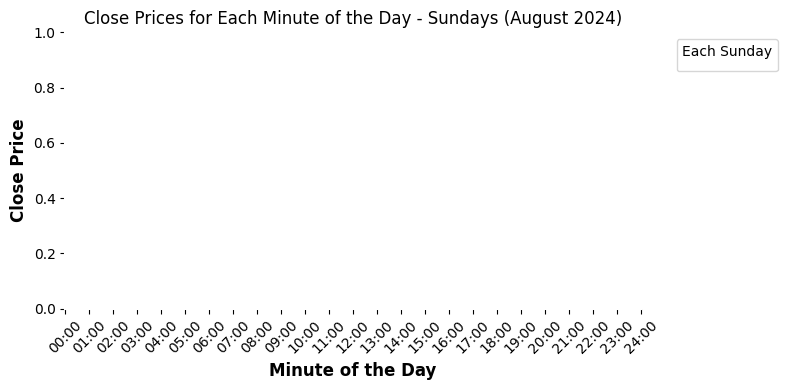

In [15]:
full_eda(data)

# __4. Technical Analysis__

## __4.1 Feature Enginnering__ (Indicators)

In [16]:
data.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

#### __4.1.1 Simple Moving Average (SMA)__

In [17]:
data['SMA_10'] = ta.sma(data['close'], length=10)
# data['SMA_20'] = ta.sma(data['close'], length=20)

#### __4.1.2 Exponential Moving Average (EMA)__

In [18]:
data['EMA_10'] = ta.ema(data['close'], length=10)

#### __4.1.3 Moving Average Convergence Divergence (MACD)__

In [19]:

macd = ta.macd(data['close'])

# Add the MACD, Signal, and Histogram to your DataFrame
# data['MACD'] = macd['MACD_12_26_9']
# data['MACD_Signal'] = macd['MACDs_12_26_9']
data['MACD_Histogram'] = macd['MACDh_12_26_9']

#### __4.1.4 Relative Strength Index (RSI)__

In [20]:
data['RSI_14'] = ta.rsi(data['close'], length=14)

#### __4.1.6 Williams %R__

In [21]:

data['Williams_%R'] = ta.willr(data['high'], data['low'], data['close'], length=14)

In [22]:
data.sample(6)

open     high      low    close    SMA_10    EMA_10  \
time                                                                          
2024-09-23 23:58:00  1.11109  1.11112  1.11107  1.11107  1.111121  1.111135   
2024-09-17 18:30:00  1.11198  1.11215  1.11198  1.11215  1.111892  1.111942   
2024-06-28 09:12:00  1.06922  1.06933  1.06922  1.06933  1.069202  1.069209   
2024-08-05 04:49:00  1.09186  1.09192  1.09172  1.09187  1.091787  1.091795   
2024-08-08 02:41:00  1.09326  1.09327  1.09323  1.09324  1.093239  1.093235   
2024-07-01 10:53:00  1.07545  1.07545  1.07521  1.07522  1.075529  1.075525   

                     MACD_Histogram     RSI_14  Williams_%R  
time                                                         
2024-09-23 23:58:00        0.000003  39.437786   -62.962963  
2024-09-17 18:30:00        0.000044  56.495742   -20.547945  
2024-06-28 09:12:00        0.000012  60.907283     0.000000  
2024-08-05 04:49:00        0.000032  54.753160   -18.461538  
2024-08-08 02:41:00        0.000004  60.758061   -37.837838  
2024-07-01 10:53:00       -0.000015  32.615469   -98.850575

## 4.2 __Feature Engineering__ (Time Variations)
### __4.2.1 Minute of the Day__

In [23]:

# Create the 'minute_of_day' feature as an integer from 1 to 1440 (based on the time index)
data['minute_of_day'] = data.index.hour * 60 + data.index.minute + 1


### __4.2.2 Hour of the Day__

In [24]:
# Create the 'hour_of_day' feature as an integer from 1 to 24 (based on the time index)
data['hour_of_day'] = data.index.hour + 1

## __4.3 Featrue Engineering__ (Calculating Slope)

I calculate the slope of the indicators over a rolling window using linear regression. The slope tells us the direction ( or indicates the rate of change in the values over time) and strength of the trend over a specified number of periods.

The calculated slope reflects the trend's direction and magnitude:

- Positive Slope: Indicates an upward trend in the data.
- Negative Slope: Indicates a downward trend.
- Slope Magnitude: The greater the magnitude, the steeper the trend.

In [25]:
def get_slope(array):
    '''
    Parameters
    array: A sequence of numerical values (e.g., SMA values) over which the slope will be calculated. The function expects this to be a NumPy array.
    Returns
    slope: The slope of the linear regression line fitted to the input array.
    '''
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

In [26]:
data.sample(5)

open     high      low    close    SMA_10    EMA_10  \
time                                                                          
2024-07-08 10:45:00  1.08331  1.08359  1.08331  1.08359  1.083325  1.083365   
2024-06-18 04:09:00  1.07308  1.07308  1.07298  1.07300  1.073285  1.073240   
2024-07-19 16:51:00  1.08856  1.08858  1.08851  1.08854  1.088601  1.088614   
2024-07-08 02:31:00  1.08269  1.08270  1.08264  1.08266  1.082693  1.082677   
2024-09-26 03:44:00  1.11351  1.11360  1.11351  1.11358  1.113598  1.113583   

                     MACD_Histogram     RSI_14  Williams_%R  minute_of_day  \
time                                                                         
2024-07-08 10:45:00       -0.000001  66.118179     0.000000            646   
2024-06-18 04:09:00       -0.000055  19.909966   -97.222222            250   
2024-07-19 16:51:00       -0.000002  44.493021   -60.344828           1012   
2024-07-08 02:31:00       -0.000011  50.909688   -66.666667            152   
2024-09-26 03:44:00       -0.000023  52.957867   -50.000000            225   

                     hour_of_day  
time                              
2024-07-08 10:45:00           11  
2024-06-18 04:09:00            5  
2024-07-19 16:51:00           17  
2024-07-08 02:31:00            3  
2024-09-26 03:44:00            4

# __5. Preparing Data__

### __5.1 Scaling__

In [27]:
# Create a new column 'log_return' based on the 'close' price
data['log_return'] = np.log(data['close'] / data['close'].shift(1))

# Remove any rows where 'log_return' is NaN (occurs at the start of the data due to shift)
data.dropna(subset=['log_return'], inplace=True)

#### re-arranging the dataset for ease of comprehension

In [28]:
# Drop the original 'close' column
data.drop(columns=['close'],inplace= True)

# Rename 'log_return' to 'close'
data.rename(columns={'log_return': 'close'},inplace=True)

In [29]:
# Now, rearrange the columns
rearranged_columns = [
    'hour_of_day',
    'minute_of_day',
    'close', 
    'SMA_10',
    'EMA_10',
    'MACD_Histogram',
    'RSI_14',
    'Williams_%R'
]

# Create a new DataFrame with the rearranged columns
data = data[rearranged_columns]

data

hour_of_day  minute_of_day     close    SMA_10    EMA_10  \
time                                                                            
2024-05-06 00:01:00            1              2  0.000195       NaN       NaN   
2024-05-06 00:02:00            1              3  0.000046       NaN       NaN   
2024-05-06 00:03:00            1              4  0.000139       NaN       NaN   
2024-05-06 00:04:00            1              5  0.000000       NaN       NaN   
2024-05-06 00:05:00            1              6  0.000074       NaN       NaN   
...                          ...            ...       ...       ...       ...   
2024-09-27 23:52:00           24           1433 -0.000054  1.116132  1.116118   
2024-09-27 23:53:00           24           1434  0.000027  1.116097  1.116086   
2024-09-27 23:54:00           24           1435  0.000000  1.116060  1.116059   
2024-09-27 23:55:00           24           1436  0.000305  1.116071  1.116099   
2024-09-27 23:56:00           24           1437  0.000036  1.116085  1.116139   

                     MACD_Histogram     RSI_14  Williams_%R  
time                                                         
2024-05-06 00:01:00             NaN        NaN          NaN  
2024-05-06 00:02:00             NaN        NaN          NaN  
2024-05-06 00:03:00             NaN        NaN          NaN  
2024-05-06 00:04:00             NaN        NaN          NaN  
2024-05-06 00:05:00             NaN        NaN          NaN  
...                             ...        ...          ...  
2024-09-27 23:52:00       -0.000040  21.481248  -100.000000  
2024-09-27 23:53:00       -0.000037  24.872148   -93.877551  
2024-09-27 23:54:00       -0.000033  24.872148   -93.877551  
2024-09-27 23:55:00       -0.000005  52.075650   -24.000000  
2024-09-27 23:56:00        0.000016  54.177809   -42.465753  

[150764 rows x 8 columns]

### __5.2 Creating training data__

#### __5.2.1 Preparing Lagged Data__

- __`df`:__ This is a DataFrame containing the original data.
  
- __`lag_steps:`__ This is an integer representing the number of time steps to lag the time unit by. It determines how many previous values of the target variable ('close') to include in the lagged DataFrame.
  
- __`lagged_df:`__ This is a new DataFrame that will store the lagged data.
  
- __`pd.DataFrame(index=df.index)`:__ This creates a new DataFrame with the same index as the original DataFrame df. The index represents the date and time of each data point.
  
- __`lagged_df['DateTime'] = df.index:`__ This creates a new column in the lagged_df DataFrame called 'DateTime', and it copies the index of the original DataFrame df. This column will store the date and time information.
  
- __`lagged_df['ActualValue'] = df['close']:`__ This creates a new column in the lagged_df DataFrame called 'ActualValue', and it copies the values from the 'close' column of the original DataFrame df. This column will store the actual values of the target variable.
  
- __`Loop:`__ This loop iterates from 1 to lag_steps (inclusive). For each iteration:
    - __`lagged_df[f'PrevValue_{i}'] = df['close'].shift(i):`__ This creates a new column in the lagged_df DataFrame for each lagged value. The column name includes the prefix 'PrevValue_' followed by the lag index i. It shifts the values of the 'close' column of the original DataFrame df upwards by i time steps and stores them in the new column. This effectively creates lagged features for the target variable.
  
- __`return lagged_df.dropna():`__ This returns the lagged DataFrame after dropping any rows with missing values (NaN). Since creating lagged features involves shifting the data, the first few rows will contain NaN values where there is no data available for the lagged features.


In [30]:
data.columns

Index(['hour_of_day', 'minute_of_day', 'close', 'SMA_10', 'EMA_10',
       'MACD_Histogram', 'RSI_14', 'Williams_%R'],
      dtype='object')

In [31]:
# go_back_by = 3

# def create_lagged_dataframe(df, lag_steps=go_back_by, columns_to_lag=None):
#     if columns_to_lag is None:
#         columns_to_lag = df.columns  # By default, lag all columns

#     lagged_df = pd.DataFrame(index=df.index)
#     lagged_df['DateTime'] = df.index
#     lagged_df['ActualValue'] = df['close']  # Keep 'ActualValue' for the close price

#     # Creating lagged columns for each selected column
#     for column in columns_to_lag:
#         for i in range(1, lag_steps + 1):
#             lagged_df[f'{column}_lag_{i}'] = df[column].shift(i)

#     return lagged_df.dropna()

# # Specify the columns you want to lag
# columns_to_lag = ['hour_of_day','minute_of_day','close', 'SMA_10','EMA_10' ,'RSI_14','Williams_%R', 'MACD_Histogram']

# lagged_df = create_lagged_dataframe(data, lag_steps=go_back_by, columns_to_lag=columns_to_lag)


go_back_by = 3

def create_lagged_dataframe(df, lag_steps=go_back_by, columns_to_lag=None):
    if columns_to_lag is None:
        columns_to_lag = df.columns  # By default, lag all columns

    lagged_df = pd.DataFrame(index=df.index)
    lagged_df['DateTime'] = df.index
    lagged_df['ActualValue'] = df['close']  # Keep 'ActualValue' for the close price

    # Creating lagged columns in reverse order for each selected column
    for column in columns_to_lag:
        for i in range(lag_steps, 0, -1):  # Start from lag_steps, go down to 1
            lagged_df[f'{column}_lag_{i}'] = df[column].shift(i)

    return lagged_df.dropna()

# Specify the columns you want to lag
columns_to_lag = ['hour_of_day','minute_of_day','close', 'SMA_10','EMA_10' ,'RSI_14','Williams_%R', 'MACD_Histogram']

lagged_df = create_lagged_dataframe(data, lag_steps=go_back_by, columns_to_lag=columns_to_lag)



In [32]:
lagged_df


DateTime  ActualValue  hour_of_day_lag_3  \
time                                                                      
2024-05-06 00:37:00 2024-05-06 00:37:00    -0.000009                1.0   
2024-05-06 00:38:00 2024-05-06 00:38:00     0.000000                1.0   
2024-05-06 00:39:00 2024-05-06 00:39:00     0.000000                1.0   
2024-05-06 00:40:00 2024-05-06 00:40:00     0.000000                1.0   
2024-05-06 00:45:00 2024-05-06 00:45:00    -0.000009                1.0   
...                                 ...          ...                ...   
2024-09-27 23:52:00 2024-09-27 23:52:00    -0.000054               24.0   
2024-09-27 23:53:00 2024-09-27 23:53:00     0.000027               24.0   
2024-09-27 23:54:00 2024-09-27 23:54:00     0.000000               24.0   
2024-09-27 23:55:00 2024-09-27 23:55:00     0.000305               24.0   
2024-09-27 23:56:00 2024-09-27 23:56:00     0.000036               24.0   

                     hour_of_day_lag_2  hour_of_day_lag_1  \
time                                                        
2024-05-06 00:37:00                1.0                1.0   
2024-05-06 00:38:00                1.0                1.0   
2024-05-06 00:39:00                1.0                1.0   
2024-05-06 00:40:00                1.0                1.0   
2024-05-06 00:45:00                1.0                1.0   
...                                ...                ...   
2024-09-27 23:52:00               24.0               24.0   
2024-09-27 23:53:00               24.0               24.0   
2024-09-27 23:54:00               24.0               24.0   
2024-09-27 23:55:00               24.0               24.0   
2024-09-27 23:56:00               24.0               24.0   

                     minute_of_day_lag_3  minute_of_day_lag_2  \
time                                                            
2024-05-06 00:37:00                 35.0                 36.0   
2024-05-06 00:38:00                 36.0                 37.0   
2024-05-06 00:39:00                 37.0                 38.0   
2024-05-06 00:40:00                 38.0                 39.0   
2024-05-06 00:45:00                 39.0                 40.0   
...                                  ...                  ...   
2024-09-27 23:52:00               1430.0               1431.0   
2024-09-27 23:53:00               1431.0               1432.0   
2024-09-27 23:54:00               1432.0               1433.0   
2024-09-27 23:55:00               1433.0               1434.0   
2024-09-27 23:56:00               1434.0               1435.0   

                     minute_of_day_lag_1  close_lag_3  close_lag_2  ...  \
time                                                                ...   
2024-05-06 00:37:00                 37.0     0.000009    -0.000009  ...   
2024-05-06 00:38:00                 38.0    -0.000009     0.000000  ...   
2024-05-06 00:39:00                 39.0     0.000000    -0.000009  ...   
2024-05-06 00:40:00                 40.0    -0.000009     0.000000  ...   
2024-05-06 00:45:00                 41.0     0.000000     0.000000  ...   
...                                  ...          ...          ...  ...   
2024-09-27 23:52:00               1432.0    -0.000009     0.000009  ...   
2024-09-27 23:53:00               1433.0     0.000009    -0.000125  ...   
2024-09-27 23:54:00               1434.0    -0.000125    -0.000054  ...   
2024-09-27 23:55:00               1435.0    -0.000054     0.000027  ...   
2024-09-27 23:56:00               1436.0     0.000027     0.000000  ...   

                     EMA_10_lag_1  RSI_14_lag_3  RSI_14_lag_2  RSI_14_lag_1  \
time                                                                          
2024-05-06 00:37:00      1.076415     60.770066     59.528857     59.528857   
2024-05-06 00:38:00      1.076416     59.528857     59.528857     58.151379   
2024-05-06 00:39:00      1.076417     59.528857     58.151379     58.151379   
2024-05-06 00:40:00      1.076417     58.151

In [33]:
lagged_df.shape

(150729, 26)

In [34]:
lagged_df.columns

Index(['DateTime', 'ActualValue', 'hour_of_day_lag_3', 'hour_of_day_lag_2',
       'hour_of_day_lag_1', 'minute_of_day_lag_3', 'minute_of_day_lag_2',
       'minute_of_day_lag_1', 'close_lag_3', 'close_lag_2', 'close_lag_1',
       'SMA_10_lag_3', 'SMA_10_lag_2', 'SMA_10_lag_1', 'EMA_10_lag_3',
       'EMA_10_lag_2', 'EMA_10_lag_1', 'RSI_14_lag_3', 'RSI_14_lag_2',
       'RSI_14_lag_1', 'Williams_%R_lag_3', 'Williams_%R_lag_2',
       'Williams_%R_lag_1', 'MACD_Histogram_lag_3', 'MACD_Histogram_lag_2',
       'MACD_Histogram_lag_1'],
      dtype='object')

#### __5.2.2 Prepare LSTM Data__

- __`lagged_df:`__ This is a DataFrame containing the lagged data.

- __`dates:`__ This variable stores the date and time information from the lagged DataFrame.

- __`X:`__ This variable stores the input features for the LSTM model. It consists of all columns from the lagged DataFrame except 'DateTime' and 'ActualValue', converted to float32 data type.

- __`y:`__ This variable stores the target variable for the LSTM model, which is the 'ActualValue' column from the lagged DataFrame, converted to float32 data type.

- __`return:`__ The function returns three variables: dates, X, and y, containing the respective data.



In [35]:
def prepare_lstm_data(lagged_df):
    dates = lagged_df['DateTime']
    X = lagged_df.drop(columns=['DateTime', 'ActualValue']).astype(np.float32)
    y = lagged_df['ActualValue'].astype(np.float32)

    return dates, X.values, y.values



dates, X, y = prepare_lstm_data(lagged_df)
print("Dates:", dates.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)


Dates: (150729,)
X shape: (150729, 24)
y shape: (150729,)


### __5.3 Spliting: Training, Validation, Testing Data__

#### __Split Data__

- __`dates:`__ This variable contains the date and time information.

- __`X:`__ This variable contains the input features for the model.

- __`y:`__ This variable contains the target variable for the model.

- __`x_train:`__ This variable contains the input features for the training set.

- __`y_train:`__ This variable contains the target variable for the training set.

- __`x_val:`__ This variable contains the input features for the validation set.

- __`y_val:`__ This variable contains the target variable for the validation set.

- __`x_test:`__ This variable contains the input features for the test set.

- __`y_test:`__ This variable contains the target variable for the test set.

- __`train_data:`__ This tuple contains the input features and target variable for the training set.

- __`val_data:`__ This tuple contains the input features and target variable for the validation set.

- __`test_data:`__ This tuple contains the input features and target variable for the test set.

- __`return:`__ The function returns three tuples: train_data, val_data, and test_data, each containing the respective input features and target variable for the corresponding set.



In [36]:
def split_data(dates, X, y):
    x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

(train_data, val_data, test_data) = split_data(dates, X, y)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = train_data, val_data, test_data


In [37]:
x_train_view = pd.DataFrame(x_train)
x_train_view


0     1     2       3       4       5         6         7   \
0       20.0  20.0  20.0  1188.0  1189.0  1190.0 -0.000009 -0.000028   
1       23.0  23.0  23.0  1346.0  1347.0  1348.0 -0.000009  0.000046   
2       23.0  23.0  23.0  1332.0  1333.0  1334.0 -0.000037  0.000037   
3       24.0  24.0  24.0  1431.0  1432.0  1433.0  0.000000 -0.000009   
4       12.0  12.0  12.0   669.0   670.0   671.0  0.000055 -0.000083   
...      ...   ...   ...     ...     ...     ...       ...       ...   
105505  13.0  13.0  13.0   732.0   733.0   734.0 -0.000126  0.000099   
105506   6.0   6.0   6.0   309.0   310.0   311.0 -0.000091  0.000018   
105507  22.0  22.0  22.0  1301.0  1302.0  1303.0  0.000036  0.000027   
105508   8.0   8.0   8.0   450.0   451.0   452.0  0.000009 -0.000080   
105509  23.0  23.0  23.0  1375.0  1376.0  1377.0  0.000081 -0.000036   

              8         9   ...        14         15         16         17  \
0      -0.000055  1.088536  ...  1.088485  56.379910  53.422726  48.000088   
1      -0.000009  1.082558  ...  1.082563  58.572975  63.991383  62.238075   
2      -0.000093  1.075415  ...  1.075424  64.437965  66.561325  57.343193   
3      -0.000027  1.117504  ...  1.117507  44.786045  43.653465  40.356289   
4       0.000129  1.088679  ...  1.088681  43.704124  40.178707  47.300144   
...          ...       ...  ...       ...        ...        ...        ...   
105505  0.000162  1.108697  ...  1.108583  44.579685  48.241268  53.639069   
105506 -0.000036  1.099174  ...  1.099205  46.834866  48.351688  45.552486   
105507 -0.000018  1.102573  ...  1.102605  58.119312  60.803070  58.128750   
105508 -0.000009  1.119792  ...  1.119783  63.623768  48.568058  47.230698   
105509 -0.000036  1.104951  ...  1.105071  61.772751  58.564091  55.461643   

               18         19         20            21            22  \
0      -40.000000 -53.125000 -88.461540 -1.154553e-05 -1.370762e-05   
1      -40.740742 -22.222221 -30.434782 -3.180502e-06 -1.581541e-06   
2      -17.500000 -11.904762 -37.500000  2.335527e-05  1.921723e-05   
3      -66.666664 -72.222221 -75.000000  8.453071e-07  8.851386e-07   
4      -69.863014 -78.688522 -55.737705 -2.363926e-05 -2.087127e-05   
...           ...        ...        ...           ...           ...   
105505 -97.183098 -81.690140 -56.338028 -2.523639e-05 -3.105280e-05   
105506 -39.285713 -32.142857 -46.428570  1.260644e-05  1.412786e-05   
105507 -45.000000 -30.000000 -40.000000 -2.638930e-06  1.650834e-06   
105508 -13.333333 -73.333336 -80.000000  8.193035e-06  1.815974e-06   
105509 -16.363636 -23.636364 -30.909090  3.454987e-05  3.748982e-05   

                  23  
0      -1.874367e-05  
1      -1.577080e-06  
2       8.413868e-06  
3      -8.025477e-07  
4      -8.411454e-06  
...              ...  
105505 -2.226915e-05  
105506  1.226605e-05  
105507  2.756428e-06  
105508 -3.135064e-06  
105509  3.514167e-05  

[105510 rows x 24 columns]

In [38]:
y_tran_view = pd.DataFrame(y_train)
y_tran_view

0
0       0.000083
1       0.000000
2      -0.000009
3       0.000018
4       0.000138
...          ...
105505  0.000207
105506  0.000045
105507 -0.000009
105508  0.000000
105509  0.000036

[105510 rows x 1 columns]

In [39]:
# OPTIONAL: Calculating the total number of instances
total_instances = len(x_train) + len(x_val) + len(x_test)

# Each set has
print("Training set:", len(x_train), "instances (", len(x_train) / total_instances * 100, "%)")
print("Validation set:", len(x_val), "instances (", len(x_val) / total_instances * 100, "%)")
print("Testing set:", len(x_test), "instances (", len(x_test) / total_instances * 100, "%)")


Training set: 105510 instances ( 69.99980096729892 %)
Validation set: 22609 instances ( 14.99976779518208 %)
Testing set: 22610 instances ( 15.00043123751899 %)



# __6. Training the model__

### __6.1 Weights and Biases__

In [40]:
!wandb login 92747ba767c68ec2ec63d2b44818eaeba8e973b9

# import subprocess

# Log in to WandB
# subprocess.run(['wandb', 'login', '92747ba767c68ec2ec63d2b44818eaeba8e973b9'])

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\tshol\.netrc


### __6.1.1 Defining the model__

In [41]:
# Define the custom Directional Accuracy (DA) metric
def directional_accuracy(y_true, y_pred):
    # Compute the true differences between consecutive time steps
    diff_true = y_true[1:] - y_true[:-1]
    
    # Compute the predicted differences between consecutive time steps
    diff_pred = y_pred[1:] - y_pred[:-1]
    
    # Check if the directions (signs) match and calculate directional accuracy
    correct_directions = tensorflow.reduce_sum(tensorflow.cast((diff_true * diff_pred) > 0, tensorflow.float32))
    
    # Divide by the number of comparisons made (n-1 due to the time difference)
    da = correct_directions / tensorflow.cast(tensorflow.shape(diff_true)[0], tensorflow.float32)
    
    # Return DA as a percentage
    return da * 100.0

run = wandb.init(
    project='first_keras_intergration',
    config={
        'learning_rate':0.001,
        'epochs' : 12,
        'batch_size': 64,
        'loss_function' : 'mean_squared_error',
        'architecture' : 'LSTM',
        }
    )



config =  wandb.config

tensorflow.keras.backend.clear_session()

#the actaul neural network
wb_model = Sequential([
    layers.Input((go_back_by,1)),

    layers.LSTM(10, return_sequences=True),
    layers.Dropout(0.2), 
    layers.LSTM(5), 
    layers.Dense(4, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),  
    layers.Dense(4, activation='relu', kernel_regularizer='l2'), 
     
    layers.Dense(1)
])

wb_model.summary()

# compile
wb_model.compile(
    loss = config.loss_function, 
    optimizer =  Adam(learning_rate=config.learning_rate),
    # metrics = ['mean_absolute_error']
    metrics=['mean_absolute_error', 'mse', RootMeanSquaredError(), directional_accuracy]
    )


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: masixole (masixoleboya). Use `wandb login --relogin` to force relogin


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 10)          │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 849 (3.32 KB)

 Trainable params: 849 (3.32 KB)

 Non-trainable params: 0 (0.00 B)

### __6.1.2 Training the model__

In [42]:
wandb_history = wb_model.fit(
    x_train,y_train, 
    epochs = config.epochs,
    batch_size =  config.batch_size,
    validation_data = (x_test, y_test),
    callbacks = [WandbMetricsLogger()]
    )

Epoch 1/12
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 1:46:17 4s/step - directional_accuracy: 3057.1428 - loss: 0.0814 - mean_absolute_error: 0.0028 - mse: 9.1100e-06 - root_mean_squared_error: 0.003 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - directional_accuracy: 2990.2603 - loss: 0.0811 - mean_absolute_error: 0.0019 - mse: 5.2224e-06 - root_mean_squared_error: 0.0023  ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - directional_accuracy: 2972.7688 - loss: 0.0807 - mean_absolute_error: 0.0017 - mse: 4.3061e-06 - root_mean_squared_error: 0.002 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - directional_accuracy: 2970.0911 - loss: 0.0803 - mean_absolute_error: 0.0016 - mse: 3.6991e-06 - root_mean_squared_error: 0.001 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - directional_accuracy: 2953.5210 - loss: 0.0799 - mean_absolute_error: 0.0015 - mse: 3.2614e-06 - root_mean_squared_error: 0.001 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - directional_accuracy: 2894.0730 - loss: 0.0796 - mean_absolute_error: 0.0014 - mse: 2.9260e-06 - root_mean_square

In [44]:
# loss, mae, mse, rmse = wb_model.evaluate(x_test, y_test, verbose=0)
# Adjust the unpacking to account for all metrics including custom metrics
loss, mae, mse, rmse, da = wb_model.evaluate(x_test, y_test, verbose=0)


#test data
predictions = wb_model.predict(x_test)

# Calculate RMSE and R-squared
rmse_manual = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

# Print evaluation metrics
print('\nTest Loss:', loss)
print('\nMean Absolute Error:', mae)
print('\nRoot Mean Squared Error (from Keras):', rmse)
print('\nRoot Mean Squared Error (manual calculation):', rmse_manual)
print('\nR-squared:', r2)
print(f"Directional Accuracy: {da}")

707/707 ━━━━━━━━━━━━━━━━━━━━ 3:22 287ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Test Loss: 9.4279659

In [44]:
wb_model.save("second_real_model.keras")

# __7. Hyperparameter Tuning__

In [45]:
def objective(trial):
    num_layers = trial.suggest_int('num_layers', 1, 5)
    layer_units = [trial.suggest_int(f'layer_units_{i}', 4, 64) for i in range(num_layers)]
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    epochs = trial.suggest_int('epochs', 2, 10)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    
    # Initialize WandB run
    # wandb.init(project='first_keras_intergration', config={
    #     'learning_rate': learning_rate,
    #     'epochs': epochs,
    #     'batch_size': 64,
    #     'loss_function': 'mean_squared_error',
    #     'architecture': 'LSTM',
    #     'dropout_rate': dropout_rate
    # })
    
    config = {
        'learning_rate': learning_rate,
        'epochs': epochs,
        'batch_size': 64,
        'loss_function': 'mean_squared_error',
        'architecture': 'LSTM',
        'dropout_rate': dropout_rate
    }

    # Clear previous session
    tensorflow.keras.backend.clear_session()

    # Create the Keras model
    wb_model = Sequential([
        layers.Input((go_back_by, 1)),
        layers.LSTM(layer_units[0], return_sequences=True),
        layers.Dropout(dropout_rate)
    ])

    for units in layer_units[1:-1]:
        wb_model.add(layers.LSTM(units, return_sequences=True))
        wb_model.add(layers.Dropout(dropout_rate))
    
    wb_model.add(layers.LSTM(layer_units[-1], return_sequences=False))
    wb_model.add(layers.Dropout(dropout_rate))
    wb_model.add(layers.Dense(4, activation=activation, kernel_regularizer='l2'))
    wb_model.add(layers.Dropout(dropout_rate))
    wb_model.add(layers.Dense(4, activation=activation, kernel_regularizer='l2'))
    wb_model.add(layers.Dense(1))

    # Compile the model
    wb_model.compile(
        loss=config['loss_function'],
        optimizer=Adam(learning_rate=config['learning_rate']),
        metrics=['mean_absolute_error', 'mean_squared_error', RootMeanSquaredError()]
    )
    
    # Train the model
    wandb_history = wb_model.fit(
        x_train, y_train,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_data=(x_test, y_test)
        # No WandB callbacks here
    )
    
    # Evaluate the model
    val_loss = wandb_history.history['val_loss'][-1]
    return val_loss


study = optuna.create_study(
    storage="sqlite:///db.sqlite3",
    direction='minimize', 
    study_name='keras_lstm_opt_1'
    )
study.optimize(
    objective, 
    n_trials=5
    )


[I 2024-09-29 16:45:04,377] A new study created in RDB with name: keras_lstm_opt_1


Epoch 1/8
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 4:04:21 9s/step - loss: 0.1272 - mean_absolute_error: 0.0390 - mean_squared_error: 0.0029 - root_mean_squared_error: 0.05 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - loss: 0.1424 - mean_absolute_error: 0.1109 - mean_squared_error: 0.0326 - root_mean_squared_error: 0.1530 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - loss: 0.1457 - mean_absolute_error: 0.1444 - mean_squared_error: 0.0455 - root_mean_squared_error: 0.19 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - loss: 0.1396 - mean_absolute_error: 0.1486 - mean_squared_error: 0.0461 - root_mean_squared_error: 0.20 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - loss: 0.1327 - mean_absolute_error: 0.1464 - mean_squared_error: 0.0444 - root_mean_squared_error: 0.19 ━━━━━━━━━━━━━━━━━━━━ 58s 36ms/step - loss: 0.1265 - mean_absolute_error: 0.1432 - mean_squared_error: 0.0424 - root_mean_squared_error: 0.19 ━━━━━━━━━━━━━━━━━━━━ 59s 37ms/step - loss: 0.1211 - mean_absolute_error: 0.1398 - mean_squared_error: 0.0403 - root_mean_squared_e

[I 2024-09-29 16:54:51,728] Trial 0 finished with value: 3.7346853787312284e-06 and parameters: {'num_layers': 5, 'layer_units_0': 11, 'layer_units_1': 55, 'layer_units_2': 13, 'layer_units_3': 22, 'layer_units_4': 54, 'activation': 'tanh', 'epochs': 8, 'dropout_rate': 0.4055761729960452, 'learning_rate': 0.04238045023448651}. Best is trial 0 with value: 3.7346853787312284e-06.


Epoch 1/10
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 4:14:35 9s/step - loss: 0.1034 - mean_absolute_error: 0.0427 - mean_squared_error: 0.0028 - root_mean_squared_error: 0.05 ━━━━━━━━━━━━━━━━━━━━ 52s 32ms/step - loss: 0.1027 - mean_absolute_error: 0.0373 - mean_squared_error: 0.0022 - root_mean_squared_error: 0.0466 ━━━━━━━━━━━━━━━━━━━━ 53s 33ms/step - loss: 0.1022 - mean_absolute_error: 0.0344 - mean_squared_error: 0.0019 - root_mean_squared_error: 0.04 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - loss: 0.1019 - mean_absolute_error: 0.0324 - mean_squared_error: 0.0017 - root_mean_squared_error: 0.04 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - loss: 0.1016 - mean_absolute_error: 0.0310 - mean_squared_error: 0.0016 - root_mean_squared_error: 0.03 ━━━━━━━━━━━━━━━━━━━━ 54s 33ms/step - loss: 0.1013 - mean_absolute_error: 0.0298 - mean_squared_error: 0.0015 - root_mean_squared_error: 0.03 ━━━━━━━━━━━━━━━━━━━━ 55s 34ms/step - loss: 0.1011 - mean_absolute_error: 0.0288 - mean_squared_error: 0.0014 - root_mean_squared_

[I 2024-09-29 17:04:57,594] Trial 1 finished with value: 2.0116059928909635e-08 and parameters: {'num_layers': 4, 'layer_units_0': 26, 'layer_units_1': 47, 'layer_units_2': 10, 'layer_units_3': 14, 'activation': 'tanh', 'epochs': 10, 'dropout_rate': 0.21999144033250123, 'learning_rate': 0.0007056104189391693}. Best is trial 1 with value: 2.0116059928909635e-08.


Epoch 1/8
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 2:44:13 6s/step - loss: 2.5602 - mean_absolute_error: 1.5690 - mean_squared_error: 2.4660 - root_mean_squared_error: 1.57 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - loss: 2.5124 - mean_absolute_error: 1.5536 - mean_squared_error: 2.4184 - root_mean_squared_error: 1.5551 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - loss: 2.4599 - mean_absolute_error: 1.5363 - mean_squared_error: 2.3662 - root_mean_squared_error: 1.53 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - loss: 2.4121 - mean_absolute_error: 1.5202 - mean_squared_error: 2.3186 - root_mean_squared_error: 1.52 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 2.3505 - mean_absolute_error: 1.4990 - mean_squared_error: 2.2571 - root_mean_squared_error: 1.50 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 2.3044 - mean_absolute_error: 1.4827 - mean_squared_error: 2.2111 - root_mean_squared_error: 1.48 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 2.2599 - mean_absolute_error: 1.4667 - mean_squared_error: 2.1667 - root_mean_squared_e

[I 2024-09-29 17:08:59,126] Trial 2 finished with value: 8.466920498051422e-09 and parameters: {'num_layers': 1, 'layer_units_0': 16, 'activation': 'sigmoid', 'epochs': 8, 'dropout_rate': 0.16665542373599732, 'learning_rate': 0.002895022987319522}. Best is trial 2 with value: 8.466920498051422e-09.


Epoch 1/8
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 2:10:21 5s/step - loss: 0.1803 - mean_absolute_error: 0.2539 - mean_squared_error: 0.0653 - root_mean_squared_error: 0.25 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.1583 - mean_absolute_error: 0.2139 - mean_squared_error: 0.0491 - root_mean_squared_error: 0.2197 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - loss: 0.1373 - mean_absolute_error: 0.1706 - mean_squared_error: 0.0359 - root_mean_squared_error: 0.18 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - loss: 0.1231 - mean_absolute_error: 0.1441 - mean_squared_error: 0.0288 - root_mean_squared_error: 0.16 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - loss: 0.1126 - mean_absolute_error: 0.1297 - mean_squared_error: 0.0246 - root_mean_squared_error: 0.15 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - loss: 0.1042 - mean_absolute_error: 0.1202 - mean_squared_error: 0.0218 - root_mean_squared_error: 0.14 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - loss: 0.0971 - mean_absolute_error: 0.1124 - mean_squared_error: 0.0197 - root_mean_squared_e

[I 2024-09-29 17:14:02,809] Trial 3 finished with value: 7.735212648185552e-07 and parameters: {'num_layers': 1, 'layer_units_0': 52, 'activation': 'sigmoid', 'epochs': 8, 'dropout_rate': 0.34434963187260803, 'learning_rate': 0.015040861411712994}. Best is trial 2 with value: 8.466920498051422e-09.


Epoch 1/6
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 4:46:09 10s/step - loss: 0.1453 - mean_absolute_error: 0.0747 - mean_squared_error: 0.0075 - root_mean_squared_error: 0.086 ━━━━━━━━━━━━━━━━━━━━ 59s 36ms/step - loss: 0.2383 - mean_absolute_error: 0.2317 - mean_squared_error: 0.1039 - root_mean_squared_error: 0.2880  ━━━━━━━━━━━━━━━━━━━━ 58s 36ms/step - loss: 0.2438 - mean_absolute_error: 0.2442 - mean_squared_error: 0.1117 - root_mean_squared_error: 0.31 ━━━━━━━━━━━━━━━━━━━━ 59s 36ms/step - loss: 0.2359 - mean_absolute_error: 0.2376 - mean_squared_error: 0.1060 - root_mean_squared_error: 0.31 ━━━━━━━━━━━━━━━━━━━━ 58s 36ms/step - loss: 0.2260 - mean_absolute_error: 0.2245 - mean_squared_error: 0.0981 - root_mean_squared_error: 0.30 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - loss: 0.2168 - mean_absolute_error: 0.2121 - mean_squared_error: 0.0908 - root_mean_squared_error: 0.28 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - loss: 0.2085 - mean_absolute_error: 0.2006 - mean_squared_error: 0.0844 - root_mean_square

[I 2024-09-29 17:20:58,059] Trial 4 finished with value: 1.089775913953872e-08 and parameters: {'num_layers': 5, 'layer_units_0': 33, 'layer_units_1': 33, 'layer_units_2': 7, 'layer_units_3': 42, 'layer_units_4': 34, 'activation': 'tanh', 'epochs': 6, 'dropout_rate': 0.1842459590197951, 'learning_rate': 0.010781849177938034}. Best is trial 2 with value: 8.466920498051422e-09.


In [46]:
best_trial = study.best_trial

print("Best hyperparameters: ", best_trial.params)


Best hyperparameters:  {'num_layers': 1, 'layer_units_0': 16, 'activation': 'sigmoid', 'epochs': 8, 'dropout_rate': 0.16665542373599732, 'learning_rate': 0.002895022987319522}


In [47]:
best_trial = study.best_trial

# Extract the best hyperparameters
best_params = best_trial.params

# Print the best hyperparameters
print("Best hyperparameters: ", best_params)

# # Save the best hyperparameters to a .txt file
# with open("best_hyperparameters.txt", "w") as file:
#     file.write("Best hyperparameters:\n")
#     for key, value in best_params.items():
#         file.write(f"{key}: {value}\n")

print("Best hyperparameters:\n")
for key, value in best_params.items():
    print(f"{key}: {value}\n")


Best hyperparameters:  {'num_layers': 1, 'layer_units_0': 16, 'activation': 'sigmoid', 'epochs': 8, 'dropout_rate': 0.16665542373599732, 'learning_rate': 0.002895022987319522}
Best hyperparameters:

num_layers: 1



layer_units_0: 16

activation: sigmoid

epochs: 8

dropout_rate: 0.16665542373599732

learning_rate: 0.002895022987319522



In [48]:
import tensorflow.keras.backend as K
K.clear_session()


### __7.2 Training tuned model__

In [ ]:
# wb_model.save("second_real_model.keras")

# __8. Evaluation (Tuned model)__

In [ ]:

# loss, mae, mse, rmse, da = wb_model_tuned.evaluate(x_test, y_test, verbose=0)


# #test data
# predictions = wb_model_tuned.predict(x_test)

# # Calculate RMSE and R-squared
# rmse_manual = np.sqrt(mean_squared_error(y_test, predictions))
# r2 = r2_score(y_test, predictions)

# # Print evaluation metrics
# print('\nTest Loss:', loss)
# print('\nMean Absolute Error:', mae)
# print('\nRoot Mean Squared Error (from Keras):', rmse)
# print('\nRoot Mean Squared Error (manual calculation):', rmse_manual)
# print('\nR-squared:', r2)
# print(f"Directional Accuracy: {da}")

# wb_model_tuned.save("LSTM_model_TESTING.keras")

42874/42874 ━━━━━━━━━━━━━━━━━━━━ 140s 3ms/step

Test Loss: 0.0009474472026340663

Mean Absolute Error: 0.02057075873017311

Root Mean Squared Error: 0.02684274

R-squared: 0.9699871713199525


In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()
